In [3]:
%matplotlib inline

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

import os
import time
import csv
import shelve
import pickle
from datetime import datetime

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib import cm

import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d
print (theano.config.device) # We're using CPUs (for now)
print (theano.config.floatX) # Should be 64 bit for CPUs

np.random.seed(0)

cpu
float64


In [4]:
FTRAIN = './Data/FKD_Train.csv'
FTEST = './Data/FKD_Test.csv'

def load(test=False, cols=None):
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        # scale target coordinates to [-1, 1] - need because we don't have bias on the net
        y = (y - 48) / 48  # 96/2=48
        y = y.astype(np.float32)
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
    else:
        y = None

    return X, y, np.array(df.columns[:-1])

X, y, y_name = load()
X_t, trash, junk = load(test=True)
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))
print("X_t.shape == {}; X_t.min == {:.3f}; X_t.max == {:.3f}".format(X_t.shape, X_t.min(), X_t.max()))
ex_x, ex_y = X[666], y[666]

X.shape == (7049, 9216); X.min == 0.000; X.max == 1.000
y.shape == (7049, 30); y.min == nan; y.max == nan
X_t.shape == (1783, 9216); X_t.min == 0.000; X_t.max == 1.000


/home/linux/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Histogram stretching completed in 20.01 seconds


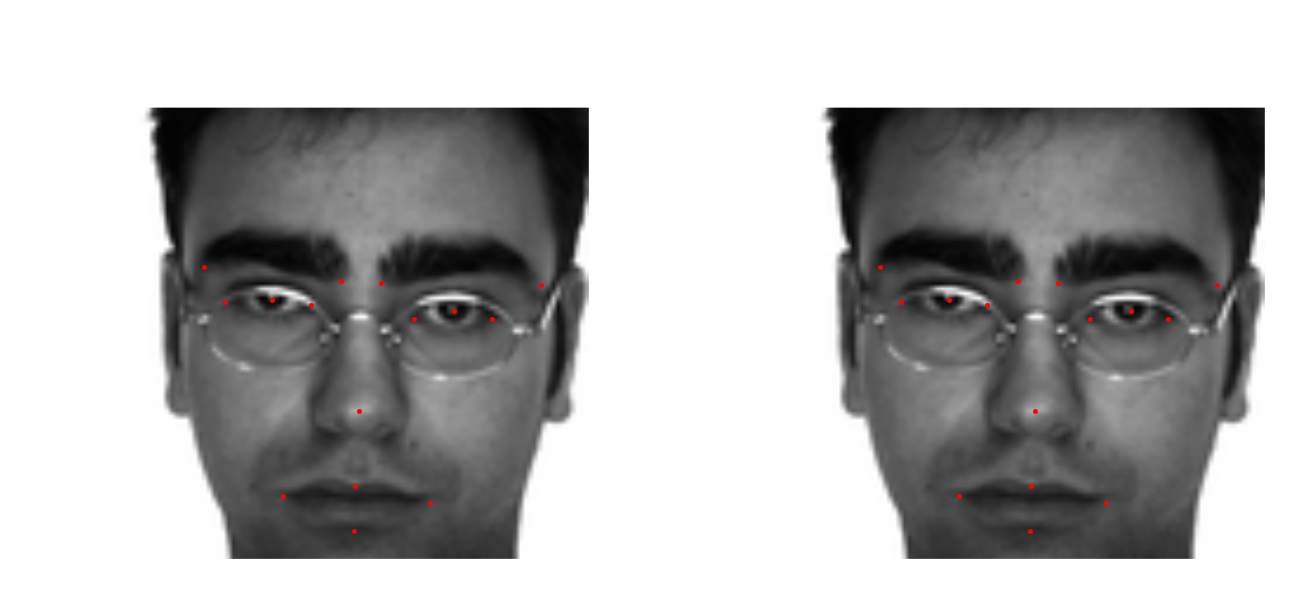

In [6]:
##### define a helper plotting function #####
def plot2(image1, p1, image2, p2):
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(image1,(96,96)), cmap = cm.gray)
    for x, y in np.reshape(p1,(len(p1)/2, 2)):
        plt.plot(x, y, 'r.')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(image2,(96,96)), cmap = cm.gray)
    for x, y in np.reshape(p2,(len(p2)/2, 2)):
        plt.plot(x, y, 'r.')
    plt.axis('off')

##### histogram stretching #####
def HistogramStretching(image):
#     a, b = min(image), max(image) 
    a, b = np.percentile(image, 5), np.percentile(image, 95)
    l, u = 0, 1
    const = 1.0*(b*l - a*u)/(b - a)
    k = 1.0*(u-l)/(b-a)
    return [k*p+const for p in image]

# plot an example
plot2(ex_x, ex_y*48+48, HistogramStretching(ex_x), ex_y*48+48)

start_time = time.time()
X = [HistogramStretching(x) for x in X]
X_t = [HistogramStretching(x) for x in X_t]
print ('Histogram stretching completed in %.2f seconds' %(time.time()-start_time))

/home/linux/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Gaussian blur completed in 712 seconds!


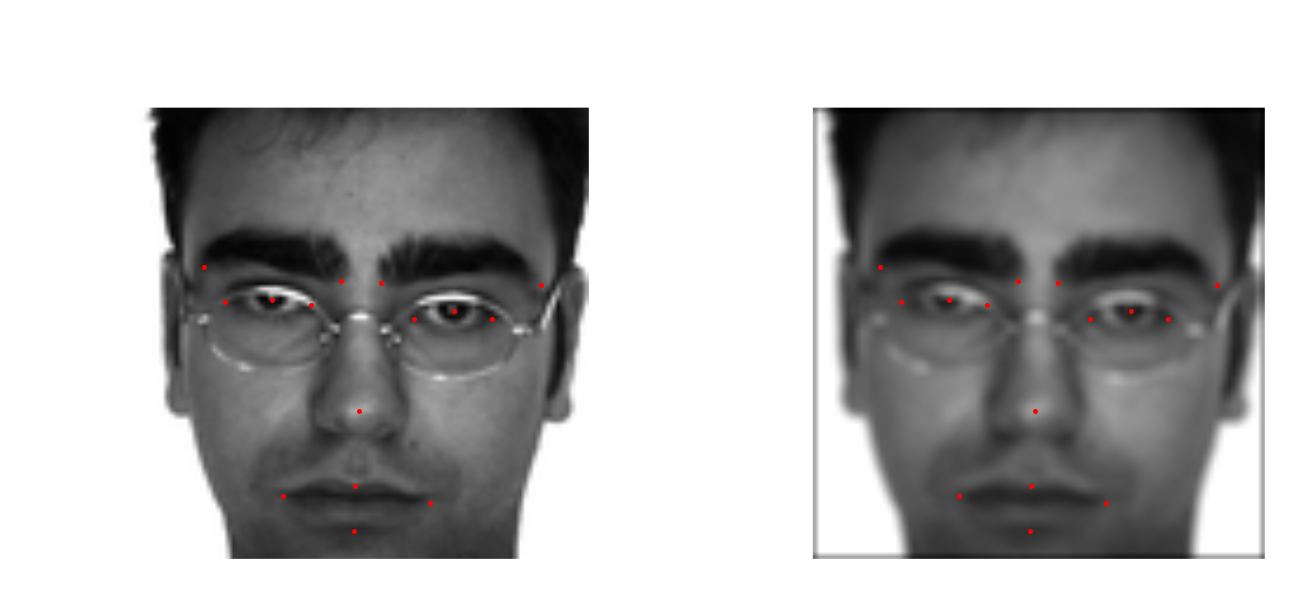

In [8]:
# define the Gaussian weights of neighbors as constant variable
sigma2 = 1.75**2
neighborIndex = [[i,j] for i in range(-1,2) for j in range(-1,2)]
gaussianWeight = np.array([np.exp(-(i**2+j**2)/(2*sigma2))/(2*np.pi*sigma2) for i,j in neighborIndex])
gaussianWeight = gaussianWeight / sum(gaussianWeight)

# function to return the index of neighborhood pixels for pixel at n
def getNeighborAndWeight(n, ncolumn, nrow):    
    # get row and column id first for index i
    (r, c) = divmod(n, ncolumn)
    # get indices for the neighbors (including self)
    neighbors = [[r+i,c+j] for i,j in neighborIndex]
    # get neighbor index and the associated Gauusian weigth
    neighborWeights = []
    for nb, gw in zip(neighbors, gaussianWeight):  # range(len(neighbors)):
        r,c = nb
        if r>=0 and r<nrow and c>=0 and c<ncolumn:                  
            neighborWeights.append([r*ncolumn + c, gw])
    return neighborWeights

# apply Gaussian blur to one image
def gaussianBlurOneSample(x):
    y = np.empty(len(x))
    for i in range(len(x)):
        neighbors = getNeighborAndWeight(i,96,96)
        y[i] = sum([x[j[0]]*j[1] for j in neighbors])
    return y

# plot an example
plot2(ex_x, ex_y*48+48, gaussianBlurOneSample(ex_x), ex_y*48+48)

# blur both training and predicting data
start_time = time.time()
X = [gaussianBlurOneSample(x) for x in X]
X_t = [gaussianBlurOneSample(x) for x in X_t]
print ('Gaussian blur completed in %.f seconds!' %(time.time()-start_time))

After merge X:(14098, 9216), y:(14098, 30)


/home/linux/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


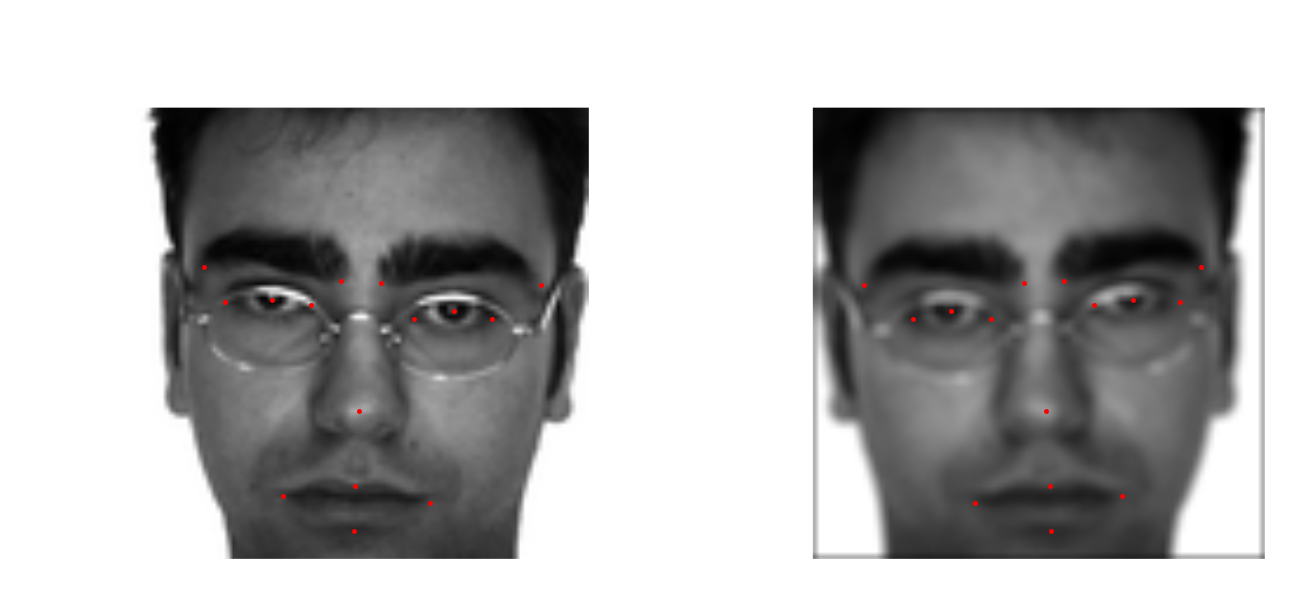

In [10]:
# flip the image
X_flip = np.reshape(np.reshape(X, (-1,1,96,96))[:, :, :, ::-1], (-1, 96*96))

# flip the x coordinate value
multiplier = [-1,1]*(int)(y.shape[1]/2)
y_flip = np.multiply([multiplier,]*y.shape[0], y)

# flip the x coordinates/column name
y_name_flip = []
for name in y_name:
    if 'left' in name.lower():
        y_name_flip.append(name.replace('left','right'))
    elif 'right' in name.lower():
        y_name_flip.append(name.replace('right','left'))
    else:
        y_name_flip.append(name)
y_name_flip=np.array(y_name_flip)
isort = [np.where(y_name_flip==x)[0][0] for x in y_name]

# combine data and align with original column
y = np.concatenate((y, y_flip[:, isort]), axis=0)
X = np.concatenate((X, X_flip), axis=0)
print ('After merge X:%s, y:%s' %(X.shape, y.shape))

plot2(ex_x, ex_y*48+48, X_flip[666], y_flip[666, isort]*48+48)

In [30]:
X_group, y_group = {}, {}
i = 0
for x,f in zip(X,y):
    picker = ~np.isnan(f)
    id = str.join(',', y_name[picker])
    if id not in X_group:
        X_group[id] = []
        y_group[id] = []
    X_group[id].append(x)
    y_group[id].append(f[picker])

feature_size = np.array([np.array(x[1]).shape for x in y_group.items()])
big_group = feature_size[:,0].argsort()
n_top = 7
print ('\nimages # vs. features # for top %d groups:' %n_top)
print (feature_size[big_group][-n_top:])

X1 = np.reshape(list(X_group.items())[big_group[-1]][1], (-1, 1, 96, 96))
X2 = np.reshape(list(X_group.items())[big_group[-2]][1], (-1, 1, 96, 96))
y1 = np.array(list(y_group.items())[big_group[-1]][1])
y2 = np.array(list(y_group.items())[big_group[-2]][1])
feature1 = list(y_group.keys())[big_group[-1]].split(',')
feature2 = list(y_group.keys())[big_group[-2]].split(',')
x_t = np.reshape(X_t, (-1, 1, 96, 96))

print ('1st training set: X1:%s - y1:%s, y1.min:%.3f, y1.max:%.3f' %(str(X1.shape), str(y1.shape), y1.min(), y1.max()))
print ('2nd training set: X2:%s - y2:%s, y2.min:%.3f, y2.max:%.3f' %(str(X2.shape), str(y2.shape), y2.min(), y2.max()))
print ('testing set: x_t:%s' %str(x_t.shape))


images # vs. features # for top 7 groups:
[[  12   26]
 [  20    6]
 [  26   28]
 [  57   28]
 [  57   28]
 [4280   30]
 [9510    8]]
1st training set: X1:(9510, 1, 96, 96) - y1:(9510, 8), y1.min:-0.986, y1.max:0.988
2nd training set: X2:(4280, 1, 96, 96) - y2:(4280, 30), y2.min:-0.964, y2.max:0.996
testing set: x_t:(1783, 1, 96, 96)


In [32]:
def getCNN(n_output):
    net = NeuralNet(
        layers=[
            ('input', layers.InputLayer),
            ('conv1', layers.Conv2DLayer),
            ('pool1', layers.MaxPool2DLayer),
            ('conv2', layers.Conv2DLayer),
            ('pool2', layers.MaxPool2DLayer),
            ('conv3', layers.Conv2DLayer),
            ('pool3', layers.MaxPool2DLayer),
            ('hidden4', layers.DenseLayer),
            ('hidden5', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
        input_shape=(None, 1, 96, 96),
        # 3 convoluational layer
        conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
        conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
        conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
        # 2 fully connected hidden layer
        hidden4_num_units=500, hidden5_num_units=500,
        # fully connected output layer, no activation function to give continuous output
        output_num_units=n_output, output_nonlinearity=None,

        update_learning_rate=0.02,
        update_momentum=0.80,
           
        regression=True,
        max_epochs=35,
        verbose=1,
        )
    return net

print ('LeNet defined!')

LeNet defined!
